## Xarray Relative Atmospheric Angular Momentum Tutorial
*Created by Cait Roufa for Data Sciences in the Geosciences - 2025*

This tutorial uses netcdf data from ERA5 to compute and plot relative atmospheric angular momentum.

In [1]:
# import packages

import xarray as xr
import numpy as np
import pandas as pd
import datetime
import math
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy as cp
import cartopy.crs as ccrs

### Find and Import Data
Data for this tutorial can be obtained from ERA5 hourly data on pressure levels: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels?tab=overview. The test dataset used is much larger than needed for this tutorial. It is recommended that you download a small subset of data from ERA5. You will need u wind. If your dataset is larger than one timestamp, use the .sel() function to select a specific timestamp from your data, and assign it to a variable.

In [2]:
# import data using xarray

df_u = xr.open_dataset('/home/scratch/croufa/era5/era5.2023.u.nc')

/home/croufa/.local/lib/python3.9/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.26.0
  warnings.warn(


In [3]:
# if you downloaded more than a day, select single timestamp and display to check data

u = df_u.sel(time='2023-04-1T00:00:00.000000000')
u

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, level: 37)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
    time       datetime64[ns] 2023-04-01
Data variables:
    u          (level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-17 03:10:23 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

#### Checking the Shape
You need to know the shape of your array if you are doing math on it. The .shape() function will print out the shape of the array. Note that it is not always in the same order that the xarray dataset dimensions are listed in. For example, the dimensions listed above are longitude: 1440, latitude: 721, level: 37, while the actual shape of the array is (37, 721, 1440) as seen below.

In [4]:
# print the shape of the array of u values
u.u.shape

(37, 721, 1440)

### Calculation
Next we need to calculate the relative AAM by taking the volumetric integral of the zonal winds in spherical coordinates. We can start with the pressure integral below, where we concatenate and do the discrete difference (with .diff()) for the u values for each pressure level along the 0th axis (37 pressure levels) and multiply by 100 to get Pa from hPa. Then we multiply this by the u values again and sum along the 0th axis, dividing by the acceleration due to gravity to get the vertical integral of u with respect to pressure.

In [5]:
# stack sfc pres to get dps
dps = np.concatenate(([0], np.diff(u.u.level))) * 100

# calculate U * dps
UDP = np.multiply(u.u, dps[:, np.newaxis, np.newaxis])

# vertical integral
vint_UDP = np.sum(UDP, axis=0) / 9.81

#### Constants
We need a few constants to help make the next part of the calculation less bulky and confusing. These values might also be used in other computations. We will define the latitude and longitude values and stack our latititude values in a column with index 1 of an array, so that it will be easier to do math with these values in the correct array location and shape. d_lambda and d_phi are the change in longitude and latitude in radians and are also stacked into appropriately sized arrays.

In [6]:
# define lats and lons
lats = u.latitude.values
lons = u.longitude.values

# stack lats into appropriately sized array
lats2D = np.stack(1440 * [lats], axis=1)

# calculate change in longitude in radians
d_lambda = 2. * math.pi / len(lons)
# stack delta longitude values into appropriately sized array
d_lambda2D  = np.stack(1440 * [np.stack(721 * [d_lambda], axis=0)], axis=1)

# calculate delta latitude in radians
d_phi = np.absolute(np.ediff1d(np.deg2rad(lats), to_begin=0))
# stack delta longitude values into appropriately sized array
d_phi2D = np.stack(1440 * [d_phi], axis=1)

### Final Calculation
For the final calculation, we multiply our vertical integral by the squared cosine of the latitude, the longitude and latitude values in radians and the radius of the earth cubed.

In [7]:
# calculates relative AAM
Mr = vint_UDP * np.cos(np.deg2rad(lats2D))**2 * d_phi2D * d_lambda2D * ((6.3781*10**6)**3)

In [8]:
# prints the Mr data array so we can check the data
Mr

<xarray.DataArray 'u' (latitude: 721, longitude: 1440)>
array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 6.60395407e+15,  6.55292894e+15,  6.50190394e+15, ...,
         6.75575276e+15,  6.70516966e+15,  6.65443650e+15],
       [ 2.69721459e+16,  2.67815891e+16,  2.65904149e+16, ...,
         2.75441589e+16,  2.73548885e+16,  2.71650096e+16],
       ...,
       [ 1.51249570e+16,  1.52274230e+16,  1.53300356e+16, ...,
         1.48118831e+16,  1.49154864e+16,  1.50200652e+16],
       [ 4.09476095e+15,  4.12249921e+15,  4.15023060e+15, ...,
         4.01139307e+15,  4.03921757e+15,  4.06707151e+15],
       [-1.62593106e-01, -1.62593106e-01, -1.62593106e-01, ...,
        -1.62593106e-01, -1.62593106e-01, -1.62593106e-01]])
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 2023-04-01

### Creating a data array and Exporting the Data
If we want to explicitly assign dimensions, coordinates, and variable names, we need to do that using xr.DataArray(). Then we can export the data array to a netcdf file. When we do a calculation in order to create a dataset, it's a good idea to assign attributes to that dataset, so that people know details about the data and how it was created. Using the .attrs() function, you can enter any arbitrary attribute names you would like, along with the descriptions for the attributes in a dictionary. This will assign attributes to the data array.

In [9]:
# create data array, assign dimensions, coordinates, variables
da = xr.DataArray(Mr, coords={'latitude':lats, 'longitude':lons}, dims=['latitude', 'longitude'], name='Mr', attrs={
    'long_name':'Relative Atmospheric Angular Momentum', 'units':'kg m^2 s^-1', 
    'description':'Relative AAM calculated for a single day 4.1.2023 at 0Z using ERA5 pressure level data', 
    'author':'Caitlin Roufa', 'date_created':'2-4-2025'})

da

<xarray.DataArray 'Mr' (latitude: 721, longitude: 1440)>
array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 6.60395407e+15,  6.55292894e+15,  6.50190394e+15, ...,
         6.75575276e+15,  6.70516966e+15,  6.65443650e+15],
       [ 2.69721459e+16,  2.67815891e+16,  2.65904149e+16, ...,
         2.75441589e+16,  2.73548885e+16,  2.71650096e+16],
       ...,
       [ 1.51249570e+16,  1.52274230e+16,  1.53300356e+16, ...,
         1.48118831e+16,  1.49154864e+16,  1.50200652e+16],
       [ 4.09476095e+15,  4.12249921e+15,  4.15023060e+15, ...,
         4.01139307e+15,  4.03921757e+15,  4.06707151e+15],
       [-1.62593106e-01, -1.62593106e-01, -1.62593106e-01, ...,
        -1.62593106e-01, -1.62593106e-01, -1.62593106e-01]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Attributes:
    long_name:     Relative Atmospheric Angular Momentum
    units:         kg m^2 s^-1
    description:   Relative AAM calculated for a single day 4.1.2023 at 0Z us...
    author:        Caitlin Roufa
    date_created:  2-4-2025

In [11]:
# export to netcdf file
da.to_netcdf('/home/croufa/datasciprojects/data_science_for_the_geosciences/lecture_examples/mr.nc')

### Read in the Data
Now we can read in the data and check to make sure that our attributes are there. Note that if you load in the data as a data array, you will see the attributes. If you load in the data as a dataset, you will not see the attributes since an xarray dataset is a collection of data arrays.

In [12]:
# load in the newly created dataset to check it
rel_aam = xr.open_dataarray('/home/croufa/datasciprojects/data_science_for_the_geosciences/lecture_examples/mr.nc')
rel_aam

<xarray.DataArray 'Mr' (latitude: 721, longitude: 1440)>
[1038240 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Attributes:
    long_name:     Relative Atmospheric Angular Momentum
    units:         kg m^2 s^-1
    description:   Relative AAM calculated for a single day 4.1.2023 at 0Z us...
    author:        Caitlin Roufa
    date_created:  2-4-2025

### Plotting the Data
We can plot the data using the quick and dirty .plot() function built in to xarray. This is a good way to get a quick look at the data in a netcdf file. If you load an xarray dataset, you will need to call the variable name that you would like to plot, for example: rel_aam['Mr'].plot().

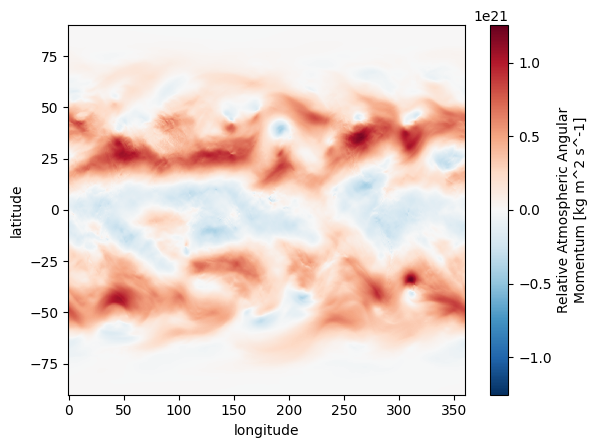

In [13]:
rel_aam.plot()

### Plotting with Cartopy
Finally, we can create a nice plot of this data using matplotlib and cartopy.

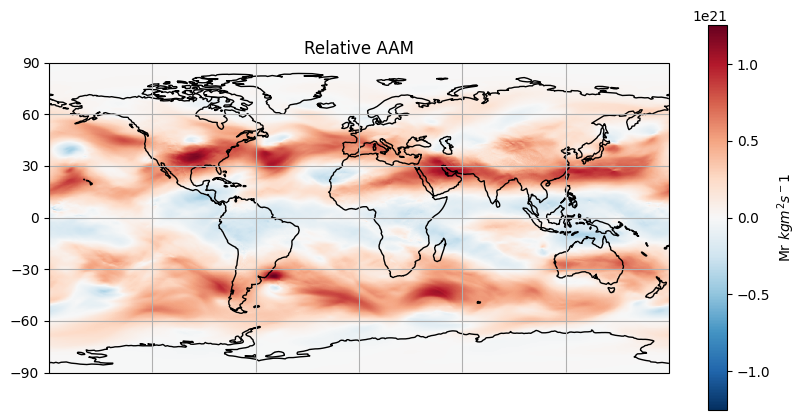

In [14]:
# set the figure size
plt.figure(figsize=(10,10))

# give the projection for the plot and add features
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cp.feature.LAND)
ax.add_feature(cp.feature.OCEAN)
ax.add_feature(cp.feature.COASTLINE)

# plot the relative aam using the longitude and latitude values in the dataset
# colorbar is centered with a divergent colormap
c = ax.pcolormesh(rel_aam.longitude, rel_aam.latitude, rel_aam, norm=colors.CenteredNorm(), cmap='RdBu_r')
plt.colorbar(c, label=r'Mr $kg m^2 s^-1$', shrink=0.5)

# set the title name
ax.set_title('Relative AAM')

# add gridlines and label the latitudes
plt.gca().set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
plt.gca().gridlines()

plt.show()